## `Dezero`'s `linear` function

```python
y = F.matmul(x, W) + b
```

This is called `linear transformation` or `affine transformation`

```python
def linear_simple(x, W, b=None):
    t = matmul(x, W)
    if b in None:
        return t
    
    y = t + b
    
    # t is only used for back propagation
    # The value inside doesn't matter so we can remove it
    # to save memory
    t.data = None
    return y
```

The most usage of memory comes from `ndarray`.<br>
So removing unncessary `ndarray` could save huge memory!<br>
At `chainer` this is automatically done by **`Aggressive Buffer Release`**

## Implement `Linear` function

### $y = xW + b$
---
## $\frac{\partial{y}}{\partial{x}} = W^{\scriptsize{T}}$
## $\frac{\partial{y}}{\partial{W}} = x^{\scriptsize{T}}$
---
## $\frac{\partial L}{\partial x} = \frac{\partial L}{\partial y} \cdot \frac{\partial{y}}{\partial{x}} = \frac{\partial L}{\partial {y}} \cdot W^{T}$
- $(N \times D) = (N \times H)(H \times D)$

## $\frac{\partial L}{\partial W} = \frac{\partial{y}}{\partial{W}} \cdot \frac{\partial L}{\partial y} = x^{\scriptsize{T}} \cdot \frac{\partial L}{\partial y}$
- $(D \times H) = (D \times N)(N \times H)$

In [3]:
from dezero import Function
from dezero.functions import sum_to
from dezero.functions import matmul

class Linear(Function):
    def forward(self, x, W, b):
        y = x.dot(W)
        if b is not None:
            y += b
        return y
    
    def backward(self, gy):
        x, W, b = self.inputs
        gb = None if b.data is None else sum_to(gy, b.shape)
        gx = matmul(gy, W.T)
        gW = matmul(x.T, gy)
        return gx, gW, gb

def linear(x, W, b=None):
    return Linear()(x, W, b)

## Nonlinear dataset

In [4]:
import numpy as np

np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

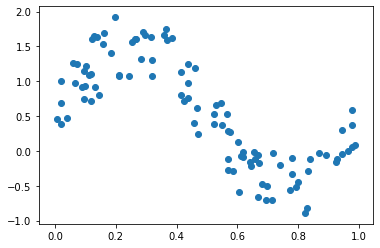

In [5]:
import matplotlib.pyplot as plt

plt.scatter(x, y);

This kind of `nonlinear` data could not be solved by `linear regression`.

## `Neural Network`

- `Linear` : linear transformation
- `Neural Network` : nonlinear transformation

For `nonlinear transformation` we need **`activation function`**<br>
One example is `sigmoid` function

In [7]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

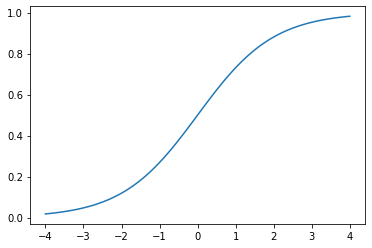

In [11]:
x = np.linspace(-4, 4, 100)
y = sigmoid(x)

plt.plot(x, y);

Another way to implement `sigmoid` using `tanh`

In [10]:
def tanh(x):
    return np.tanh(x)

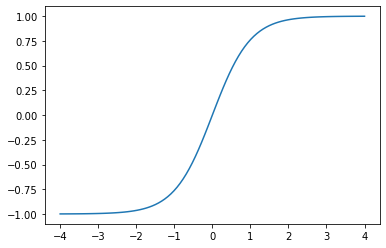

In [12]:
x = np.linspace(-4, 4, 100)
y = tanh(x)

plt.plot(x, y);

To make `sigmoid` with `tanh`
- stretch x axis 2 times
- reduce y axis 2 times
- move the y value 0.5 upper

In [13]:
def sigmoid_using_tanh(x):
    return tanh(0.5 * x) * 0.5 + 0.5 

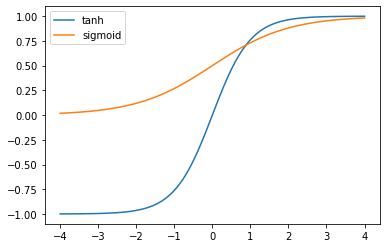

In [15]:
x = np.linspace(-4, 4, 100)
tanh_y = tanh(x)
sigmoid_y = sigmoid_using_tanh(x)

plt.plot(x, tanh_y, label='tanh')
plt.plot(x, sigmoid_y, label='sigmoid')
plt.legend();

## Implement `Neural Network`

1. Dataset
2. Weight Initialization
3. Model
4. Train
5. Predict

### 1. Dataset

In [86]:
import numpy as np
from dezero import Variable
import dezero.functions as F

np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

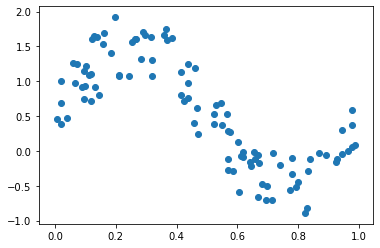

In [87]:
import matplotlib.pyplot as plt

plt.scatter(x, y);

### 2. Weight Initialization

In [107]:
# I: input
# H: hidden
# O: output

I, H, O = 1, 10, 1
W1 = Variable(0.01 * np.random.randn(I, H))
b1 = Variable(np.zeros(H))
W2 = Variable(0.01 * np.random.randn(H, O))
b2 = Variable(np.zeros(O))

We use `np.zeros` to easily make `ndarray` that doesn't break at **len(Variable)**
- `len(Variable(np.array(1))` -> ERROR
- `len(Variable(np.zeros(1))` -> GOOD :) !

In [108]:
np.zeros(1)

array([0.])

In [109]:
W1, b1

(Variable([[ 0.00771791  0.00823504  0.02163236  0.01336528 -0.00369182 -0.00239379
             0.0109966   0.00655264  0.00640132 -0.01616956]]),
 Variable([0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]))

In [110]:
W2, b2

(Variable([[-0.00024326]
           [-0.00738031]
           [ 0.00279925]
           [-0.0009815 ]
           [ 0.00910179]
           [ 0.00317218]
           [ 0.00786328]
           [-0.00466419]
           [-0.00944446]
           [-0.0041005 ]]),
 Variable([0.]))

### 3. Model

In [111]:
import dezero.functions as F

def neural_network(x):
    y = F.linear(x, W1, b1)
    y = F.sigmoid(y)
    y = F.linear(y, W2, b2)
    return y

### 4. Train

In [112]:
lr = 0.2
iters = 10000

for i in range(iters):
    y_pred = neural_network(x)
    loss = F.mean_squared_error(y, y_pred)
    
    W1.cleargrad()
    b1.cleargrad()
    W2.cleargrad()
    b2.cleargrad()
    
    loss.backward()
    
    W1.data -= lr * W1.grad.data
    b1.data -= lr * b1.grad.data
    W2.data -= lr * W2.grad.data
    b2.data -= lr * b2.grad.data
    
    if i % 1000 == 0:
        print(loss)

Variable(0.8497718314877383)
Variable(0.2511875064699414)
Variable(0.24788481609580215)
Variable(0.24350143977748862)
Variable(0.2353066098027341)
Variable(0.21660193370946593)
Variable(0.15967767407669428)
Variable(0.0879725578779695)
Variable(0.0775101347097287)
Variable(0.07692128879681835)


In [113]:
W1, b1

(Variable([[-1.65650047 -1.78969349 -1.83441896 -1.77407933 -9.46293569 -0.52748808
            -1.41026415 -1.73287142 -1.79274399 -3.0533807 ]]),
 Variable([0.04463853 0.03844748 0.05334619 0.03548747 4.68026034 0.92249975
           0.10312187 0.03554807 0.03921101 1.8448195 ]))

In [114]:
W2, b2

(Variable([[-1.34631601]
           [-1.56840201]
           [-1.64118894]
           [-1.54201639]
           [ 5.25098304]
           [ 0.25740884]
           [-0.97163366]
           [-1.47099274]
           [-1.57345349]
           [-1.78531075]]),
 Variable([1.97469391]))

### 5. Predict

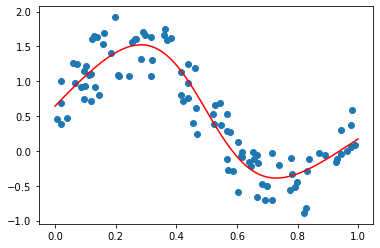

In [140]:
import matplotlib.pyplot as plt

plt.scatter(x, y)

test_x = Variable(np.linspace(0, 1, 100).reshape(100, 1))
test_y = neural_network(test_x)

plt.plot(test_x.data, test_y.data, c='r');